In [11]:
from gdc.data_access import *
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error
from arch import arch_model
import matplotlib.pyplot as plt

In [9]:
import pandas as pd

In [2]:
df_temp_real.head()

,Temp,station_name,lon,lat,alt
time,,,,,
2023-01-01 00:00:00,287.350006,b'ORLY',2.397,48.717999,86.0
2023-01-01 01:00:00,287.549988,b'ORLY',2.397,48.717999,86.0
2023-01-01 02:00:00,287.549988,b'ORLY',2.397,48.717999,86.0
2023-01-01 03:00:00,287.350006,b'ORLY',2.397,48.717999,86.0
2023-01-01 04:00:00,287.049988,b'ORLY',2.397,48.717999,86.0


In [3]:
df_temp_real_24.head()

,Temp,station_name,lon,lat,alt
time,,,,,
2024-01-01 00:00:00,280.149994,b'ORLY',2.397,48.717999,86.0
2024-01-01 01:00:00,280.049988,b'ORLY',2.397,48.717999,86.0
2024-01-01 02:00:00,279.450012,b'ORLY',2.397,48.717999,86.0
2024-01-01 03:00:00,279.250000,b'ORLY',2.397,48.717999,86.0
2024-01-01 04:00:00,279.049988,b'ORLY',2.397,48.717999,86.0


<Axes: xlabel='time'>

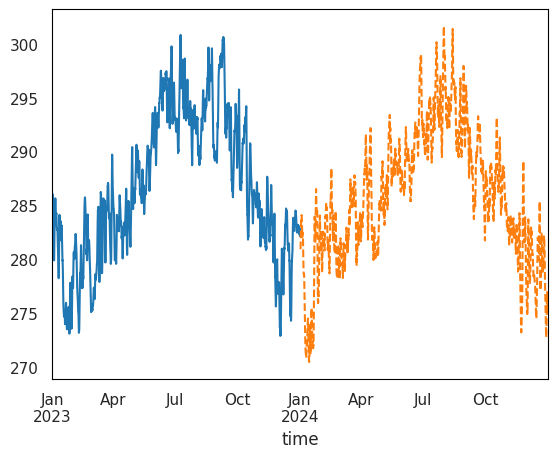

In [7]:
df_temp_real[CB.temp].rolling(24).mean().plot()
df_temp_real_24[CB.temp].rolling(24).mean().plot()

In [10]:
df_temp_real["hour"] = df_temp_real.index.hour
df_temp_real["dow"] = df_temp_real.index.dayofweek       # 0=Mon
df_temp_real["month"] = df_temp_real.index.month

df_temp_real["hour"]  = pd.Categorical(df_temp_real["hour"],  categories=range(24), ordered=False)
df_temp_real["dow"]   = pd.Categorical(df_temp_real["dow"],   categories=range(7),  ordered=False)
df_temp_real["month"] = pd.Categorical(df_temp_real["month"], categories=range(1,13), ordered=False)

# One-hot encode (omit one category to avoid collinearity)
D = pd.get_dummies(df_temp_real[["hour","dow","month"]],
                   drop_first=True, prefix=["h","d","m"], dtype=float)

In [ ]:
X = pd.concat([df_temp_real[[CB.temp]], D], axis=1)

y = df_merged_real[CB.price]

model = SARIMAX(
    y,
    exog=sm.add_constant(X),
    order=(2,0,0),
    seasonal_order=(1,0,0,24),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

res = model.fit(disp=False)
print(res.summary())
y_hat = res.fittedvalues

r2 = r2_score(y, y_hat)
print("Pseudo R²:", r2)